Load DATA

In [93]:
import pandas as pd

# Load the dataset
df = pd.read_csv('IMDB.csv')  # Replace with your file path
print(df.head())  # Inspect the first 5 rows

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


1. Understand the Dataset

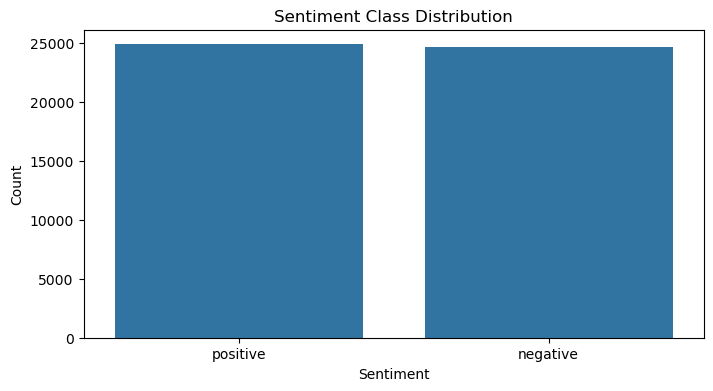

In [121]:
# Check sentiment distribution
sentiment_counts = df['sentiment'].value_counts()

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64


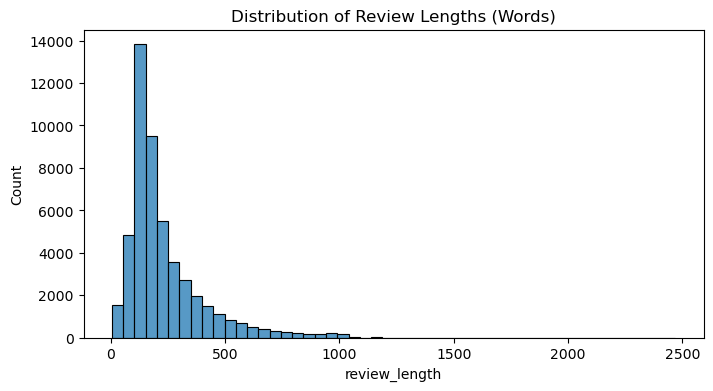

Top 20 frequent words: [('the', 568735), ('a', 306960), ('and', 301919), ('of', 283625), ('to', 261850), ('is', 203056), ('in', 169981), ('I', 132498), ('that', 126818), ('this', 113726), ('it', 107916), ('/><br', 100974), ('was', 92658), ('as', 83130), ('with', 82569), ('for', 80919), ('The', 67317), ('but', 66282), ('on', 61197), ('movie', 60762)]

Sample review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\medse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
# Check text length (character/word count)
df['review_length'] = df['review'].apply(lambda x: len(x.split()))  # Word count
print(df['review_length'].describe())  # Mean, max, min, etc.

# Plot review lengths
plt.figure(figsize=(8, 4))
sns.histplot(df['review_length'], bins=50)
plt.title('Distribution of Review Lengths (Words)')
plt.show()

# Check for common words (before preprocessing)
from collections import Counter
import nltk
nltk.download('stopwords')

all_words = ' '.join(df['review']).split()
word_freq = Counter(all_words)
print("Top 20 frequent words:", word_freq.most_common(20))

# Check for emojis/HTML tags
sample_review = df['review'].iloc[0]  # Inspect a random review
print("\nSample review:", sample_review)

2. Preprocess the Text Data

In [96]:
import re
import contractions
import demoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
demoji.download_codes()  # For emoji handling

def preprocess_text(text, 
                    handle_contractions=True,
                    handle_emojis="convert",  # "convert", "remove", or None
                    remove_stopwords=True,
                    lemmatize=True):
    """
    Preprocesses text with multiple NLP steps.
    
    Args:
        text (str): Input text to clean
        handle_emojis: "convert" to text, "remove", or None to ignore
    Returns:
        list: Cleaned tokens
    """
    
    # 1. Remove URLs and HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+|<.*?>', '', text, flags=re.MULTILINE)
    
    # 2. Handle contractions
    if handle_contractions:
        text = contractions.fix(text)
    
    # 3. Handle emojis
    if handle_emojis == "convert":
        text = demoji.replace_with_desc(text, sep=" ")
    elif handle_emojis == "remove":
        text = demoji.replace(text, '')
    
    # 4. Convert to lowercase
    text = text.lower()
    
    # 5. Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 6. Tokenization
    tokens = word_tokenize(text)
    
    # 7. Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    
    # 8. Lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

# Example usage
sample_text = "Check out this link: http://example.com 😊 Don't you love NLP? #Awesome"
clean_tokens = preprocess_text(sample_text)
print("Original:", sample_text)
print("Cleaned:", clean_tokens)

Original: Check out this link: http://example.com 😊 Don't you love NLP? #Awesome
Cleaned: ['check', 'link', 'smiling', 'face', 'smiling', 'eye', 'love', 'nlp', 'awesome']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\medse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\medse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\medse\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\medse\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [97]:
import pandas as pd
import re

def clean_data(df):
    # Drop empty columns
    df.dropna(axis=1, how='all', inplace=True)

    # Drop rows with missing values in 'Text' or 'Score'
    df.dropna(subset=['review', 'sentiment'], inplace=True)

    # Remove duplicate rows based on the 'Text' column
    df = df.drop_duplicates(subset=['review'])

    # Clean text columns
    def clean_text(text):
        return re.sub(r'[^a-zA-Z\s]', '', str(text).lower())

    df['review'] = df['review'].apply(clean_text)


    # Save the cleaned dataset
    df.to_csv('cleaned_reviews.csv', index=False)

In [98]:
clean_data(df)

C:\Users\medse\AppData\Local\Temp\ipykernel_28180\2859676150.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].apply(clean_text)


In [109]:
import swifter
df = pd.read_csv('cleaned_reviews.csv')
df['cleaned_review'] = df['review'].swifter.apply(
    lambda x: preprocess_text(str(x), handle_emojis="convert")
)

Pandas Apply:   0%|          | 0/49582 [00:00<?, ?it/s]

In [110]:
print(df.head())

                                              review sentiment  review_length  \
0  one of the other reviewers has mentioned that ...  positive            307   
1  a wonderful little production br br the filmin...  positive            162   
2  i thought this was a wonderful way to spend ti...  positive            166   
3  basically theres a family where a little boy j...  negative            138   
4  petter matteis love in the time of money is a ...  positive            230   

                                      cleaned_review  
0  [one, reviewer, mentioned, watching, oz, episo...  
1  [wonderful, little, production, br, br, filmin...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, family, little, boy, jake, think, ...  
4  [petter, matteis, love, time, money, visually,...  


4. Split the Dataset

In [111]:
import pandas as pd  # Save the function in a separate file

# Load data
df = pd.read_csv('cleaned_reviews.csv')

# Preprocess all reviews
df['cleaned_review'] = df['review'].apply(
    lambda x: preprocess_text(str(x), handle_emojis="convert")
)

# Split into train/val/test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    df['cleaned_review'],  # Use cleaned data
    df['sentiment'],
    test_size=0.2,
    stratify=df['sentiment'],
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Save splits
train_df = pd.DataFrame({'cleaned_review': X_train, 'sentiment': y_train})
val_df = pd.DataFrame({'cleaned_review': X_val, 'sentiment': y_val})
test_df = pd.DataFrame({'cleaned_review': X_test, 'sentiment': y_test})

train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [112]:
sample = df['review'].head(10).apply(lambda x: preprocess_text(str(x)))
print(sample)

0    [one, reviewer, mentioned, watching, oz, episo...
1    [wonderful, little, production, br, br, filmin...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, family, little, boy, jake, think, ...
4    [petter, matteis, love, time, money, visually,...
5    [probably, alltime, favorite, movie, story, se...
6    [sure, would, like, see, resurrection, dated, ...
7    [show, amazing, fresh, innovative, idea, first...
8    [encouraged, positive, comment, film, looking,...
9    [like, original, gut, wrenching, laughter, lik...
Name: review, dtype: object


3. Feature Engineering

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF (fit only on training data)
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Transform training data
X_train_tfidf = tfidf.fit_transform(X_train.astype(str))  # Convert tokens to strings if needed

# Transform validation/test data
X_val_tfidf = tfidf.transform(X_val.astype(str))
X_test_tfidf = tfidf.transform(X_test.astype(str))

5. Model Selection && 6. Train and Evaluate

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Evaluate on validation set
y_val_pred = model.predict(X_val_tfidf)
print("Validation Report:\n", classification_report(y_val, y_val_pred))

# Test set evaluation (final step)
y_test_pred = model.predict(X_test_tfidf)
print("Test Report:\n", classification_report(y_test, y_test_pred))

Validation Report:
               precision    recall  f1-score   support

    negative       0.89      0.87      0.88      2470
    positive       0.88      0.90      0.89      2488

    accuracy                           0.89      4958
   macro avg       0.89      0.88      0.89      4958
weighted avg       0.89      0.89      0.89      4958

Test Report:
               precision    recall  f1-score   support

    negative       0.89      0.88      0.89      2470
    positive       0.88      0.89      0.89      2489

    accuracy                           0.89      4959
   macro avg       0.89      0.89      0.89      4959
weighted avg       0.89      0.89      0.89      4959



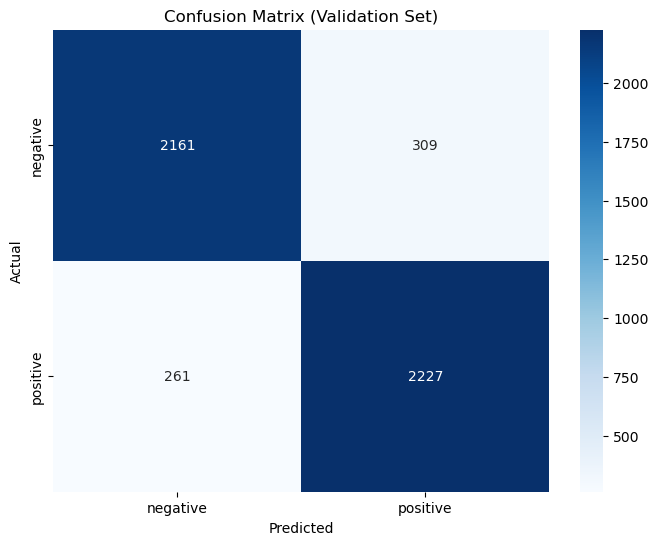

In [115]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on validation set
y_val_pred = model.predict(X_val_tfidf)

# Classification report
#print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [116]:
y_test_pred = model.predict(X_test_tfidf)
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Test Set Accuracy: 0.8864690461786651
Test Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.88      0.89      2470
    positive       0.88      0.89      0.89      2489

    accuracy                           0.89      4959
   macro avg       0.89      0.89      0.89      4959
weighted avg       0.89      0.89      0.89      4959



TF-IDF vectorizer and model Save & Test

In [117]:
import joblib

# Save the TF-IDF vectorizer and model
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(model, 'sentiment_model.pkl')

['sentiment_model.pkl']

In [122]:
def predict_sentiment(text):
    # Preprocess the input text (use the same preprocessing steps as during training)
    cleaned_tokens = preprocess_text(text)  # Replace with your preprocessing function
    cleaned_text = ' '.join(cleaned_tokens)
    
    # Vectorize the text
    vectorized_text = tfidf.transform([cleaned_text])
    
    # Predict sentiment
    prediction = model.predict(vectorized_text)[0]
    return prediction

# Test with sample reviews
#sample_reviews = [
    "This product is amazing! Highly recommended!",
    "Terrible quality. Do not buy this.",
    "It's okay, but could be better.",
    "It's "
#]

sample_reviews = [
    "Cheaply made and arrived damaged. Never again!",
    "Misleading advertising. Total letdown.",
    "Complicated to use and unreliable. Frustrating experience.",
    "Worst purchase ever. Constant issues from day one.",
    "Fast shipping and top-notch quality. Will buy again!",
    "User-friendly design and outstanding performance. A game-changer!",
    "Absolutely love this product! It exceeded all my expectations.",
    "Five stars! Works exactly as advertised."
]

for review in sample_reviews:
    sentiment = predict_sentiment(review)
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n{'-'*50}")

Review: Cheaply made and arrived damaged. Never again!
Predicted Sentiment: negative
--------------------------------------------------
Review: Misleading advertising. Total letdown.
Predicted Sentiment: negative
--------------------------------------------------
Review: Complicated to use and unreliable. Frustrating experience.
Predicted Sentiment: positive
--------------------------------------------------
Review: Worst purchase ever. Constant issues from day one.
Predicted Sentiment: negative
--------------------------------------------------
Review: Fast shipping and top-notch quality. Will buy again!
Predicted Sentiment: positive
--------------------------------------------------
Review: User-friendly design and outstanding performance. A game-changer!
Predicted Sentiment: positive
--------------------------------------------------
Review: Absolutely love this product! It exceeded all my expectations.
Predicted Sentiment: positive
--------------------------------------------------